<a href="https://colab.research.google.com/github/prathamnishad/Computer-Vision/blob/master/Time_series_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dense
from keras.layers import Dropout
import warnings
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
os.chdir("/content/drive/My Drive")

In [3]:
df=pd.read_csv(r"wrfrun.csv")
df=df[["yyyymmdd","Time","Pres","Spd","Relative Humidity","Den","Temp","Precipitation Rate"]]
df.columns=["ymd","time","pres","speed","hum","den","tem","precip"]
df=df[1:]
df["ymd"]=df["ymd"].apply(lambda x: str(x)[:-2])
df["time"]=df["time"].apply(lambda x: '0'*(4-len(str(x)))+str(x)+"00")
df.time=df.ymd.astype(object)+df.time.astype(object)
df.drop(columns="ymd",inplace=True)
df.time=df.time.apply(lambda x: pd.to_datetime(x))
for i in ["pres","speed","hum","den","tem","precip"]:
    df[i]=df[i].astype(float)
df.head()

,time,pres,speed,hum,den,tem,precip
1,2007-03-01 00:00:00,964.8,5.67,62.1,1.273,-12.3,0.000
2,2007-03-01 01:00:00,964.9,5.61,66.8,1.274,-12.4,0.001
3,2007-03-01 02:00:00,965.0,5.04,76.3,1.275,-12.8,0.002
4,2007-03-01 03:00:00,964.9,4.19,77.4,1.276,-13.0,0.004
5,2007-03-01 04:00:00,964.7,3.17,76.4,1.276,-13.0,0.005


In [4]:
df.set_index('time',inplace=True)
df.head()

,pres,speed,hum,den,tem,precip
time,,,,,,
2007-03-01 00:00:00,964.8,5.67,62.1,1.273,-12.3,0.000
2007-03-01 01:00:00,964.9,5.61,66.8,1.274,-12.4,0.001
2007-03-01 02:00:00,965.0,5.04,76.3,1.275,-12.8,0.002
2007-03-01 03:00:00,964.9,4.19,77.4,1.276,-13.0,0.004
2007-03-01 04:00:00,964.7,3.17,76.4,1.276,-13.0,0.005


In [8]:
# df.drop(columns="target",inplace=True)
df.head()

,pres,speed,hum,den,tem,precip
time,,,,,,
2007-03-01 00:00:00,964.8,5.67,62.1,1.273,-12.3,0.000
2007-03-01 01:00:00,964.9,5.61,66.8,1.274,-12.4,0.001
2007-03-01 02:00:00,965.0,5.04,76.3,1.275,-12.8,0.002
2007-03-01 03:00:00,964.9,4.19,77.4,1.276,-13.0,0.004
2007-03-01 04:00:00,964.7,3.17,76.4,1.276,-13.0,0.005


In [16]:
train=df[:-len(df)//5]
test=df[-len(df)//5:]
print(len(train)+len(test),len(df))

87672 87672


In [17]:
scaler=MinMaxScaler()
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)
test

array([[0.91078067, 0.29213938, 0.55025381, 0.70886076, 0.33955857,
        0.        ],
       [0.89591078, 0.31888169, 0.43959391, 0.70253165, 0.34465195,
        0.        ],
       [0.88289963, 0.34643436, 0.35431472, 0.69936709, 0.34295416,
        0.        ],
       ...,
       [0.64869888, 0.43881686, 0.86598985, 0.42088608, 0.58404075,
        0.        ],
       [0.63011152, 0.48055105, 0.85888325, 0.41455696, 0.58743633,
        0.        ],
       [0.61524164, 0.49878444, 0.84771574, 0.40506329, 0.5959253 ,
        0.        ]])

In [0]:
train_x=[]
train_y=[]
for i in range(0,len(train),24):
  train_x.append(np.array(train[i:i+24]))
for i in range(24,len(train),24):
  train_y.append(train[i][1])
train_x=np.array(train_x)
if len(test[-1]!=24):
  train_x=train_x[:-1]

In [45]:
test_x=[]
test_y=[]
for i in range(0,len(test),24):
  test_x.append(np.array(test[i:i+24]))
for i in range(24,len(test),24):
  test_y.append(test[i][1])
if len(test[-1]!=24):
  test_x=test_x[:-1]
test_x=np.array(test_x)
print(len(test_x),len(test_y))

730 730


In [46]:
test_x[1][0][1]==test_y[0]

True

In [43]:
train_x=np.array(train_x)

type(train_x)

numpy.ndarray

In [0]:
fig,ax=plt.subplots(6,1,figsize=(12,15))
n=0
for i in ["pres","speed","hum","den","tem","precip"]:
  ax[n].plot(df[i][::500])
  ax[n].set_title(i)
  n+=1
plt.show()

In [53]:
model=Sequential()
model.add(LSTM(128,input_shape=(24,6)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse",)
model.fit(train_x,train_y,epochs=50,batch_size=32,validation_data=(test_x,test_y))

Train on 2922 samples, validate on 730 samples
Epoch 1/50
2922/2922 [==============================] - 6s 2ms/step - loss: 0.0189 - val_loss: 0.0068
Epoch 2/50
2922/2922 [==============================] - 4s 1ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 3/50
2922/2922 [==============================] - 4s 1ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 4/50
2922/2922 [==============================] - 4s 1ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 5/50
2922/2922 [==============================] - 4s 1ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 6/50
2922/2922 [==============================] - 4s 1ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 7/50
2922/2922 [==============================] - 4s 1ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 8/50
2922/2922 [==============================] - 4s 1ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/50
2922/2922 [==============================] - 4s 1ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 10/50
2922/2922 [============

In [0]:
test_x=np.array(test_x)

In [0]:
x=train[3:3+24]
y=train[3+25][1]

In [56]:
len(x)

24

In [81]:
pred=model.predict(scaler.transform(inverse_train[3:3+24]).reshape(1,24,6))
print(f"pred= {pred}")
print(f"actual value is {inverse_train[3+24][1]}")
print(f"above transformed value is {scaler.transform([[0,inverse_train[3+24][1],0,0,0,0]])}")
print(f" predicted transformed value is {scaler.inverse_transform([[0,pred,0,0,0,0]])}")

pred= [[0.4147416]]
actual value is 10.3
above transformed value is [[-17.24349442   0.40680713  -0.02233503  -3.35126582   0.52801358
    0.        ]]
 predicted transformed value is [[927.7         10.49582282   2.2          1.059      -31.1
    0.        ]]


In [0]:
print(model.predict(test_x[0].reshape(1,24,6)))
print(test_y[0])

In [68]:
print(scaler.inverse_transform([[0.46029173419773095,0,0,0,0,0]]))

[[ 9.52463695e+02  2.60000000e-01  2.20000000e+00  1.05900000e+00
  -3.11000000e+01  0.00000000e+00]]


In [82]:
pred=model.predict(test_x)

len(pred)

730

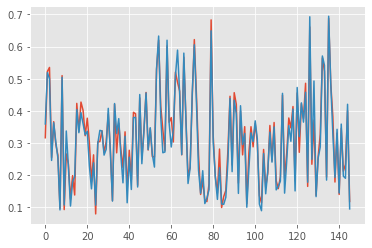

In [87]:
plt.style.use("ggplot")
plt.plot(pred[::5])
plt.plot(test_y[::5])

plt.show()